# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path

from tqdm import tqdm

# Define Classes/Functions

In [40]:
CHANNELS = 8  # CA state-space dimensionality
FILTERS = 16  # Number of filter applied to each channel
RADIUS = 2  # Radius of kernel
HIDDEN = 16 # Number of hidden neurons
DIM = 16  # Embedder output dimensionality
RES = 64  # Resolution of CA grid

POP = 30  # Number of CA rules in population
HNM_STEPS = 3000  # Max number of steps to mine for a hard-negative sample before while-loop terminates
EPOCHS = 1000  # Number of training epochs

G_KERNEL = 11


# def augment(x):
#     xx = x + 0.4*torch.randn_like(x) + 0.2*torch.randn(x.size(0)).cuda().view(x.size(0),1,1,1)
#     xx = xx*(2*torch.randint(2,(x.size(0),)).float().cuda().view(x.size(0),1,1,1)-1)
#     xx = xx[:,:,8:-8,8:-8]
    
#     return xx


def totalistic(x):
    z = 0.125 * (x + x.flip(2) + x.flip(3) + x.flip(2).flip(3))
    z = z + 0.125 * (x.transpose(2, 3) + x.transpose(2, 3).flip(2) + x.transpose(2, 3).flip(3) + x.transpose(2, 3).flip(
        2).flip(3))
    z = z - z.mean(3).mean(2).unsqueeze(2).unsqueeze(3)
    return z

def modf(x):
    z = 0.5 * (x + x.flip(2))
    z = z - z.mean(3).mean(2).unsqueeze(2).unsqueeze(3)
    
    return z

def create_growth_kernel(mu=0, sigma=1, r=1, k=5, betas=1):
    # mu: mean
    # sigma: variance
    # r: max radius 
    # k: kernsel size

#     X, Y = torch.meshgrid(torch.linspace(-r, r, k), torch.linspace(-r, r, k))
#     R = torch.sqrt(X**2 + Y**2)
#     kc = 2*torch.exp(-(R-mu)**2/(2*sigma**2)) - 1
    
    X, Y = np.meshgrid(torch.linspace(-r, r, k), np.linspace(-r, r, k))
    R = np.sqrt(X**2 + Y**2)
    kc = 2*np.exp(-(R-mu)**2/(2*sigma**2)) - 1
    
    return kc


class Rule(nn.Module):
    def __init__(self):
        super().__init__()
        Rk = RADIUS*2 + 1 
        self.filter1 = nn.Parameter(torch.randn(FILTERS*CHANNELS, 1, Rk, Rk).abs()/sqrt(FILTERS*CHANNELS))
        self.bias1 = nn.Parameter(0*torch.randn(FILTERS*CHANNELS))
        
        self.filter2 = nn.Conv2d(FILTERS*CHANNELS, HIDDEN, 1, padding_mode='circular')
        nn.init.orthogonal_(self.filter2.weight, gain=2)
        nn.init.zeros_(self.filter2.bias)
        self.filter3 = nn.Conv2d(HIDDEN, CHANNELS, 1, padding_mode='circular', bias=False)
        nn.init.orthogonal_(self.filter3.weight, gain=2)
#         nn.init.zeros_(self.filter3.bias)


class CA(nn.Module):
    def __init__(self):
        super().__init__()

        self.rule = Rule()
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-3)
        
#         self.g_kernel = torch.cat(CHANNELS*[torch.cuda.FloatTensor(create_growth_kernel(r=2, k=G_KERNEL)).unsqueeze(0)]).unsqueeze(1)
#         self.g_kernel = self.g_kernel * torch.randn((CHANNELS, 1, 1, 1)).cuda()
        
#         r = nn.Parameter(torch.rand(CHANNELS)*2.5 + 0.5)
#         mu = nn.Parameter(torch.rand(CHANNELS)*r)
#         sigma = nn.Parameter(torch.rand(CHANNELS)*2 + 0.01)
        
#         r = 2
#         mu =  1
#         sigma = 0.2

        r = np.random.rand(CHANNELS)*2.5 + 0.5
        mu = np.random.rand(CHANNELS)*r
        sigma = np.random.rand(CHANNELS)*2 + 0.01
        
        self.g_kernel = [torch.cuda.FloatTensor(
            create_growth_kernel(r=r[i], 
                                 mu=mu[i],
                                 sigma=sigma[i],
                                 k=G_KERNEL)).unsqueeze(0) for i in range(0, CHANNELS)
                        ]
        self.g_kernel = torch.cat(self.g_kernel).unsqueeze(1)

    def initGrid(self, BS):
        self.psi = torch.cuda.FloatTensor(2 * np.random.rand(BS, CHANNELS, RES, RES) - 1)
        
    def get_living_mask(self, alpha):
        alpha_channel = self.psi[:, 3:4, :, :]
        alpha_channel = F.pad(alpha_channel, (RADIUS, RADIUS, RADIUS, RADIUS), mode='circular')

        alive_mask = F.max_pool2d(alpha_channel, kernel_size=2*RADIUS+1, stride=1, padding=RADIUS) > alpha
        alive_mask = alive_mask[:, :, RADIUS:-RADIUS, RADIUS:-RADIUS] 
#         alive_mask = alive_mask * (torch.abs(self.psi) <= 1).type(torch.cuda.FloatTensor)
        
#         max_t, _ = torch.max(torch.abs(self.psi)<10, dim=0)
#         alive_mask = alive_mask * max_t.type(torch.cuda.FloatTensor)
        
        return alive_mask
        

    def forward(self):
        '''
        The first filter applies a depthwise convolution to the CA grid. Each channel in the filter is applied to its corresponding channel in the CA grid.
        The second and third filters are 1x1 convolutions which act to mix the channels.
        If I understand this correctly, this is essentially applying a depthwise seperable convolution operation on the input (but I am a bit uncertain).
        '''
#         weights = torch.cat(CHANNELS*[totalistic(self.rule.filter1)])
#         bias = torch.cat(CHANNELS*[self.rule.bias1])
        
#         living_mask = (self.psi[:, 3:4, :, :] > 0.1).type(torch.cuda.FloatTensor)
#         living_mask = living_mask * (torch.abs(self.psi) < 1).type(torch.cuda.FloatTensor)
#         alpha = 0.1
#         alive_mask = self.get_living_mask(alpha=alpha)
        
        weights = totalistic(self.rule.filter1)
#         weights = modf(self.rule.filter1)
        bias = self.rule.bias1
        
        # z = F.conv2d(self.psi, weight=weights, bias=bias, padding=2, groups=CHANNELS)
        pad_psi = F.pad(self.psi, (RADIUS, RADIUS, RADIUS, RADIUS), 'circular')
        z = F.conv2d(pad_psi, weight=weights, bias=bias, padding=0, groups=CHANNELS)
        
        z = F.leaky_relu(z)
        z = F.leaky_relu(self.rule.filter2(z))
        z = self.rule.filter3(z)
        
        # growth 
        g_RADIUS = int(self.g_kernel.size()[3]/2)
        z = F.pad(z,(g_RADIUS, g_RADIUS, g_RADIUS, g_RADIUS), 'circular')
        z = F.conv2d(z, weight=self.g_kernel, padding=0, groups=CHANNELS)
        
#         self.psi = torch.tanh(pad_psi[:, :, RADIUS:-RADIUS, RADIUS:-RADIUS]  + 0.1*z)
#         self.psi = torch.clamp(pad_psi[:, :, RADIUS:-RADIUS, RADIUS:-RADIUS] + z, 0, 1)
        self.psi = (self.psi + z)
        self.psi = torch.clamp(self.psi, 0, 1)
        
#         post_alive_mask = self.get_living_mask(alpha=alpha)
#         self.psi = self.psi * alive_mask * post_alive_mask
        

    def cleanup(self):
        del self.psi


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(3, 16, 3, padding=1)
        nn.init.orthogonal_(self.c1.weight, gain=sqrt(2))
        self.p1 = nn.AvgPool2d(2)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)
        nn.init.orthogonal_(self.c2.weight, gain=sqrt(2))
        self.p2 = nn.AvgPool2d(2)
        self.c3 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.orthogonal_(self.c3.weight, gain=sqrt(2))
        self.p3 = nn.AvgPool2d(2)
        self.c4 = nn.Conv2d(64, 128, 3, padding=1)
        nn.init.orthogonal_(self.c4.weight, gain=sqrt(2))
        self.p4 = nn.AvgPool2d(2)
        self.c5 = nn.Conv2d(128, 256, 3, padding=1)
        nn.init.orthogonal_(self.c5.weight, gain=sqrt(2))
        
        # with two fully connected layers in the end
        self.d1 = nn.Linear(256, 128)
        self.d2 = nn.Linear(128, DIM)

    def forward(self, x):
        z = self.p1(F.leaky_relu(self.c1(x)))
        z = self.p2(F.leaky_relu(self.c2(z)))
        z = self.p3(F.leaky_relu(self.c3(z)))
        z = self.p4(F.leaky_relu(self.c4(z)))
        z = self.c5(F.leaky_relu(z)).mean(3).mean(2)
        z = self.d1(F.leaky_relu(z))
        z = self.d2(z)

        z = z/torch.sqrt(1+torch.sum(z**2,1).unsqueeze(1))        

        return z


def findHardNegative(zs):
    '''
    For N steps, find a pair of CAs (i, k) such that the distance between their embeddings is larger than some threshold.
    If such a pairing is found, break out of the loop and return the indices of the pair and the number of steps it took to find the pair.
    '''
    step = 0

    while step < HNM_STEPS:
        i = np.random.randint(zs.shape[0])
        j = i
        k = np.random.randint(zs.shape[0] - 1)
        if k >= i:
            k += 1

        i2 = np.random.randint(zs.shape[1])
        j2 = np.random.randint(zs.shape[1] - 1)
        if j2 >= i2:
            j2 += 1
        k2 = np.random.randint(zs.shape[1])

        z1 = zs[i, i2]
        z2 = zs[j, j2]
        z3 = zs[k, k2]

        delta = np.sqrt(np.sum((z1 - z2) ** 2, axis=0)) - np.sqrt(np.sum((z1 - z3) ** 2, axis=0)) 
        if delta >= -TRIPLET_MARGIN:
            break
        step += 1

    return i, k, step

# Test

In [14]:
name = 'model_p500_20200825-152225'
PATH = 'models/' + name + '/model_p500'
CA_run = CA().cuda()
checkpoint = torch.load(PATH)
CA_run.load_state_dict(checkpoint['model_state_dict'][7]);


RuntimeError: Error(s) in loading state_dict for CA:
	size mismatch for rule.filter1: copying a param with shape torch.Size([32, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([4, 1, 11, 11]).
	size mismatch for rule.bias1: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for rule.filter2.weight: copying a param with shape torch.Size([16, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 4, 1, 1]).
	size mismatch for rule.filter3.weight: copying a param with shape torch.Size([8, 16, 1, 1]) from checkpoint, the shape in current model is torch.Size([4, 16, 1, 1]).
	size mismatch for rule.filter3.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([4]).

In [49]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
# embed = Embedder().cuda()

650


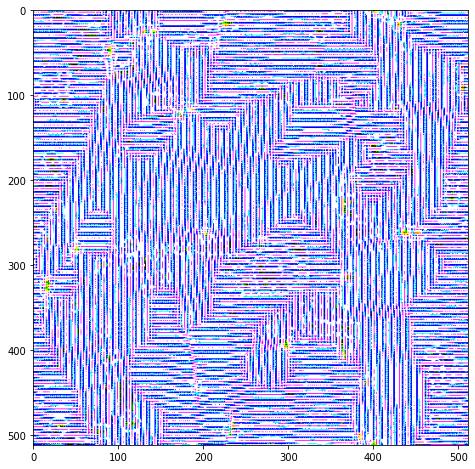

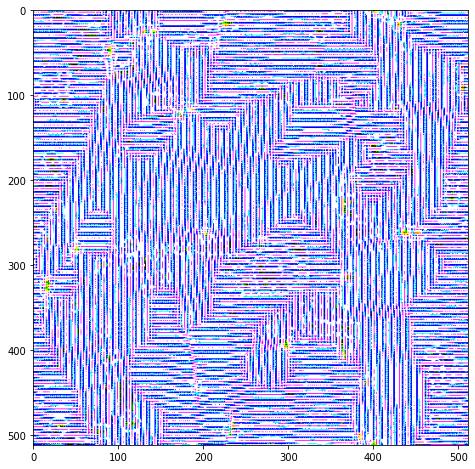

In [50]:
CA_run = population[0]
CA_run.initGrid(BS=1)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((CHANNELS, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 0.9
# x[:, 3:, 1:-1:, 1:-1] = 0.9

x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) > 0.99).unsqueeze(0) 
# x = torch.cuda.FloatTensor(np.random.random((CHANNELS, RES, RES)) ).unsqueeze(0) 
CA_run.psi = x

imgs = []

timeSteps = 700


with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
#         nx = nx[:, :, 0]
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [ ]:
population = [CA().cuda() for i in range(POP)]
timestr = time.strftime("%Y%m%d-%H%M%S")
name_tag = '-with-growth'
name = f'model_p{int(len(population))}' + name_tag
PATH = 'models/' + name + '_' + timestr

if not path.exists(PATH):
    makedirs(PATH)

# for i in range(1,len(population)):
#     population[i].rule.filter1.data = population[0].rule.filter1.data.detach()
#     population[i].rule.bias1.data = population[0].rule.bias1.data.detach()
#     population[i].rule.filter2.weight.data = population[0].rule.filter2.weight.data.detach()
#     population[i].rule.filter3.weight.data = population[0].rule.filter3.weight.data.detach()
#     population[i].rule.filter2.bias.data = population[0].rule.filter2.bias.data.detach()
#     population[i].rule.filter3.bias.data = population[0].rule.filter3.bias.data.detach()


embed = Embedder().cuda()

emb_err = []
ca_err = []
hard_frac = []

e_optim = torch.optim.Adam(embed.parameters(), lr=1e-4)
tloss = nn.TripletMarginLoss(margin=TRIPLET_MARGIN)

CBS = 10 # should be even number
# EBS = 15
# ESTEPS = 25
EBS = 5  # scaled by population size?
ESTEPS = 100


writer = SummaryWriter(log_dir='runs/' + name + '_' + timestr)
for epoch in range(EPOCHS):
    print(f'Epoch: {epoch}')
    e_loss = []
    c_loss = []
    h_loss = []

    zs = []
    xs = []
    with torch.no_grad():
        print('Generating embeddings for CAs...')
        for ca in population:
            lzs = []
            ca.initGrid(CBS)
            K = np.random.randint(25, 50)
            for j in range(K):
                ca.forward()
                
            x = []
            for j in range(E_INDIM):
                x.append(ca.psi[:,0:1,:,:])
                ca.forward()
            x = torch.cat(x,1)
            
            lzs.append(embed.forward(x).cpu().detach().numpy())
            # lxs.append(ca.psi.cpu().detach().numpy())
            zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
            ca.cleanup()
        zs = np.concatenate(zs, axis=0)

    # Train embedder
    print('Training embedder')
    for i in range(ESTEPS):
        x1 = []
        x2 = []
        x3 = []

        for j in range(EBS):
            a, b, hard = findHardNegative(zs)

            CA1 = population[a]
            CA2 = population[b]

            with torch.no_grad():
                CA1.initGrid(2)
                CA2.initGrid(1)

#                 K1 = np.random.randint(25, 50)
#                 K2 = np.random.randint(25, 50)
                
                K1 = 25
                K2 = 25

                for k in range(K1):
                    CA1.forward()
                    
                c1 = []
                for k in range(E_INDIM):
                    c1.append(CA1.psi[:,0:1,:,:])
                    CA1.forward()
                c1 = torch.cat(c1,1)
                
                for k in range(K2):
                    CA2.forward()

                c2 = []
                for k in range(E_INDIM):
                    c2.append(CA2.psi[:,0:1,:,:])
                    CA2.forward()
                c2 = torch.cat(c2,1)
                
                # is there a reason we're throwing these into CPU and then throwing them back on GPU later? 
                im1 = c1[0].cpu().detach().numpy()
                im2 = c1[1].cpu().detach().numpy()
                im3 = c2[0].cpu().detach().numpy()

                CA1.cleanup()
                CA2.cleanup()

            x1.append(im1)  # anchor 
            x2.append(im2)  # positive 
            x3.append(im3)  # negative
            h_loss.append(hard)  

        x1 = torch.cuda.FloatTensor(np.array(x1))
        x2 = torch.cuda.FloatTensor(np.array(x2))
        x3 = torch.cuda.FloatTensor(np.array(x3))

        e_optim.zero_grad()
        z1 = embed.forward(x1)
        z2 = embed.forward(x2)
        z3 = embed.forward(x3)

        loss = tloss(z1, z2, z3)
        loss.backward()
        e_optim.step()

        e_loss.append(loss.cpu().detach().item())

    emb_err.append(np.mean(e_loss))
    hard_frac.append(np.mean(h_loss))
#     print(f'emb: {emb_err[-1]}, hard_frac: {hard_frac[-1]}')

    # Train CAs
    print('Training CAs')
    for ii in range(len(population) // 2):
        i = np.random.randint(len(population))
        CA1 = population[i]
        z1 = zs[i, 0]
        z2 = zs[i, 1]

        d12 = np.sqrt(np.sum((z1 - z2) ** 2, axis=0))
        step = 0
        while step < HNM_STEPS:
            j = np.random.randint(len(population) - 1)
            if j >= i:
                j += 1

            z3 = zs[j, 0]

            d13 = np.sqrt(np.sum((z1 - z3) ** 2, axis=0))
            if d12 - d13 > -TRIPLET_MARGIN:
                break

            step += 1

        CA2 = population[j]

        CA1.optim.zero_grad()
        CA2.optim.zero_grad()

        CA1.initGrid(CBS)
        CA2.initGrid(CBS//2)

#         S1 = np.random.randint(25, 50)
#         S2 = np.random.randint(25, 50)
        
        S1 = 25
        S2 = 25

        for k in range(S1):
            CA1.forward()
            
        c1 = []
        for k in range(E_INDIM):
            c1.append(CA1.psi[:,0:1,:,:])
            CA1.forward()
        c1 = torch.cat(c1,1)

        for k in range(S2):
            CA2.forward()
            
        c2 = []
        for k in range(E_INDIM):
            c2.append(CA2.psi[:,0:1,:,:])
            CA2.forward()
        c2 = torch.cat(c2,1)

        im = CA1.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im = (255 * np.clip(im, 0, 1)).astype(np.uint8)
        im = Image.fromarray(im)
        
        im2 = CA2.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im2 = (255 * np.clip(im2, 0, 1)).astype(np.uint8)
        im2 = Image.fromarray(im2)
#         im = CA1.psi.detach().cpu().numpy()[0, 0:1, :, :].transpose(1, 2, 0) * 0.5 + 0.5
#         im = (im * 255).astype('uint8')
#         im = Image.fromarray(im, 'RGB')
        
#         fpath = path.join('frames', timestr, 'epoch_' + str(epoch).zfill(3))
        fpath = path.join('frames', timestr, 'CA', 'CA_' + str(i).zfill(5)) # images saved according to CA
        fpath2 = path.join('frames', timestr, 'CA', 'CA_' + str(j).zfill(5)) 
        fpath_epoch = path.join('frames', timestr, 'all', 'epoch_' + str(epoch).zfill(3)) # images saved according to epoch
        if not path.exists(fpath):
            makedirs(fpath)
        if not path.exists(fpath2):
            makedirs(fpath2)
        if not path.exists(fpath_epoch):
            makedirs(fpath_epoch)
        im.save(path.join(fpath, str(i).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im.save(path.join(fpath_epoch, 'CA_' + str(i).zfill(5) + '.png'))
        im2.save(path.join(fpath2, str(j).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im2.save(path.join(fpath_epoch, 'CA_' + str(j).zfill(5) + '.png'))
        
        z1 = embed.forward(c1)
        z3 = embed.forward(c2)

        z2 = z1[CBS//2:]
        z1 = z1[:CBS//2]

        loss = tloss(z1,z2,z3)
        
        for CA in population:
            for p in CA.parameters():
                if p.grad is not None:
                    p.grad = p.grad / (1e-8 + torch.norm(p.grad))
        
        loss.backward()
        CA1.optim.step()
        CA2.optim.step()

        c_loss.append(loss.cpu().detach().item())

        CA1.cleanup()
        CA2.cleanup()

    ca_err.append(np.mean(c_loss))
#     print(f'CA_loss: {ca_err[-1]}')
    writer.add_scalar('Loss/CA', ca_err[-1], epoch)
    writer.add_scalar('Loss/Emb', emb_err[-1], epoch)
    writer.add_scalar('Hard negative steps', hard_frac[-1], epoch)

    np.savetxt(PATH + '/embed.txt', np.array(emb_err))
    np.savetxt(PATH + '/ca.txt', np.array(ca_err))
    np.savetxt(PATH + '/hard.txt', np.array(hard_frac))

stats = {
    'emb_loss': emb_err,
    'ca_loss': ca_err,
    'hard': hard_frac    
}

torch.save({
    'epoch': epoch,
    'model_state_dict': [CA.state_dict() for CA in population],
    'embedder_state_dict': embed.state_dict(),
    'embedder_optimizer_state_dict': e_optim.state_dict(),
    'stats': stats
}, PATH + '/' + name)

In [13]:
# name = 'model_p100_e1000_randomstart'
fname = time.strftime("%Y%m%d-%H%M%S")
PATH = 'models/' + name + '_' + fname

if not path.exists(PATH):
    makedirs(PATH)

stats = {
    'emb_loss': emb_err,
    'ca_loss': ca_err,
    'hard': hard_frac    
}

torch.save({
    'epoch': epoch,
    'model_state_dict': [CA.state_dict() for CA in population],
    'embedder_state_dict': embed.state_dict(),
    'embedder_optimizer_state_dict': e_optim.state_dict(),
    'stats': stats
}, PATH + '/' + name)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_model(name):
    folder = 'models/' + name + '/'
    er = np.loadtxt(folder + 'embed.txt')
    cr = np.loadtxt(folder + "ca.txt")
    h = np.loadtxt(folder + "hard.txt")
    
    return er, cr, h

def make_figs(er, cr, h):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(h, '.')
    ax[0].set_title('Avg. Hard-negative mining steps')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Steps')

    ax[1].plot(er, '.', label='Embedder')
    ax[1].plot(cr, '.', label='CA')
    ax[1].set_title('CA and Discriminator triplet loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Tloss')
    plt.legend()

Text(0, 0.5, 'Steps')

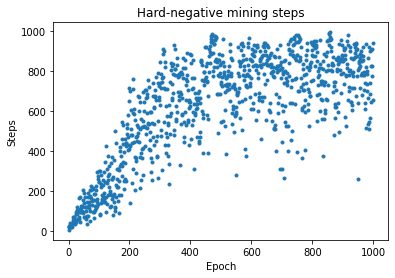

In [5]:
name = 'model_p500_20200825-152225'
make_figs(*load_model(name))

name = 'model_p100_20200824-192902'
make_figs(*load_model(name))

name = 'model_p100_20200826-200433'
make_figs(*load_model(name))
